This notebook contents are:

    (0) load model
    (1) image recognition
    (2) estimating RF(receptive field) by reverse correlation 
    (3) estimating RF by activation maximization
    (4) estimating prefered image by activation maximization (not only for first layer)
    (5) encoding and decoding experiment using Alexnet instead of a real brain
    (6) estimating tuning curve for orientation stimulus
    (7) decoding orientation using estimated tuning curve
    (8) inverse CNN : image reconstruction from unit activities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imresize
from scipy import interpolate
import pickle
import pandas as pd
import time
import os

import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import serializers
from chainer import optimizers




/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#directory setting
data_dir = 'data'
model_dir = 'model'
fig_dir = 'fig'
temp_dir = 'temp'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [3]:

def scaling(img):
    #最大値を1、最小値が0になるように線形変換をする。
    temp = img - np.min(img)
    temp = temp/np.max(temp)
    return temp

In [4]:

class Alex(chainer.Chain):
    #structure of Alexnet
    def __init__(self):
        super(Alex, self).__init__(
            conv1=L.Convolution2D(None,  96, 11, stride=4),
            conv2=L.Convolution2D(None, 256,  5, pad=2),
            conv3=L.Convolution2D(None, 384,  3, pad=1),
            conv4=L.Convolution2D(None, 384,  3, pad=1),
            conv5=L.Convolution2D(None, 256,  3, pad=1),
            fc6=L.Linear(None, 4096),
            fc7=L.Linear(None, 4096),
            fc8=L.Linear(None, 1000)
        )
        self.dropout_rate = 0.1
    
        
    def __call__(self, x, layers):
        ret = {}
        en = layers[-1]
        h = self.conv1(x)
        if 'conv1' in layers:
            ret.update({'conv1':h})
            if en == 'conv1':
                return ret
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2) 
        h = self.conv2(h)
        if 'conv2' in layers:
            ret.update({'conv2':h})
            if en == 'conv2':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.max_pooling_2d(F.local_response_normalization(
            F.relu(h)), 3, stride=2)
        h = self.conv3(h)
        if 'conv3' in layers:
            ret.update({'conv3':h})
            if en == 'conv3':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.conv4(h)
        if 'conv4' in layers:
            ret.update({'conv4':h})
            if en == 'conv4':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.conv5(h)
        if 'conv5' in layers:
            ret.update({'conv5':h})
            if en == 'conv5':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.max_pooling_2d(F.relu(h), 3, stride=2)
        h = self.fc6(h)
        if 'fc6' in layers:
            ret.update({'fc6':h})
            if en == 'fc6':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.fc7(h)
        if 'fc7' in layers:
            ret.update({'fc7':h})
            if en == 'fc7':
                return ret
        h = F.dropout(h,ratio = self.dropout_rate)
        h = F.relu(h)
        h = self.fc8(h)
        if 'fc8' in layers:
            ret.update({'fc8':h})
        h = F.softmax(h)
        if 'prob' in layers:
            ret.update({'prob':h})
        return ret

# (0) load model

In [5]:
model = Alex()
serializers.load_hdf5('{}/Alex.h5'.format(model_dir),model)

# (1) image recognition

In [6]:
def prepare(img):
    #convert PIL Image to numpy array for chainer
    
    #to numpy array
    img = np.asarray(img)
    if not img.shape == (1,3,227,227):
        #resize image to the size used in Alexnet
        img = imresize(img,np.array([227,227]))
        #to BGR, which is used color order in Alexnet
        img = img[:,:,[2,1,0]]
        #reorder img to order used in chainer and convert dtype to np.float32 for chainer
        img = img.transpose(2,0,1).astype(np.float32)
        #add batch dimension for chainer
        img = np.expand_dims(img,axis=0)
    return img

def check_label(prediction):
    #ラベルを読み込む
    categories = np.loadtxt('{}/labels.txt'.format(data_dir), str, delimiter="\n")

    # スコアとラベルを紐づけスコアの高い順にソートする
    result = zip(prediction.data.reshape((prediction.data.size,)), categories)
    result = sorted(result, reverse=True)

    # 上位10個の結果を表示する
    for i, (score, label) in enumerate(result[:10]):
        print('{:>3d} {:>6.2f}% {}'.format(i + 1, score * 100, label))

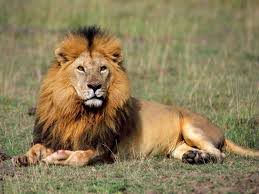

In [11]:
img = Image.open('{}/lion.png'.format(data_dir))
img

In [12]:
img = prepare(img)
prediction = model(img, layers = 'prob')['prob']
check_label(prediction)

/Users/admin/.pyenv/versions/anaconda2-5.1.0/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


  1  47.29% lion, king of beasts, Panthera leo
  2   4.46% chow, chow chow
  3   2.99% Pomeranian
  4   2.49% collie
  5   2.16% dhole, Cuon alpinus
  6   1.29% Shetland sheepdog, Shetland sheep dog, Shetland
  7   1.28% red wolf, maned wolf, Canis rufus, Canis niger
  8   1.28% Norwich terrier
  9   1.26% red fox, Vulpes vulpes
 10   1.04% timber wolf, grey wolf, gray wolf, Canis lupus


# (2) estimating RF by reverse correlation 

In [13]:
pos = np.array([14,14]) #where unit
n_sample = 1000

In [14]:
layer_name = 'conv1'

seed = 1
np.random.seed(seed)
img_inps = np.random.rand(n_sample,3,227,227).astype(np.float32) * 255
ua_list = []
#loop for collecting unit activations when random noise images are given
for k in range(n_sample):
    if np.mod(k,100)==0:
        print(k)
    img_inp = img_inps[k:k+1]
    feature = model(img_inp,layers=layer_name)[layer_name]
    unit_activation = feature[0,:,pos[0],pos[1]].data
    ua_list.append(unit_activation)

ua_list = np.array(ua_list)

0
100
200
300
400
500
600
700
800
900


In [24]:
img_inps = np.load('{}/img_random_noise.npy'.format(temp_dir))
ua_list = np.load('{}/unit_act_random_noise.npy'.format(temp_dir))

In [15]:
#estimate RF
#unit activation * input
rf_rc = np.tensordot(img_inps,ua_list,axes = [0,0]).transpose(3,1,2,0)/n_sample

In [16]:
def imshow_with_zoom(img,zoom = False,d=4,pos=pos):
    #show receptive field
    
    #img  : img you want to show
    #zoom : if zoom is True, you zoom and show the image
    #d    : zoom した場合の大きさ。もし0であれば、conv1のRFのサイズになる。
    #pos  : position you want to zoom
    
    if zoom:
        plt.imshow(img[pos[0]*4-d:pos[0]*4 + 11 + d , pos[1]*4 - d : pos[1]*4 + 11 +d])
    else:
        plt.imshow(img)
    plt.axis('off')


In [17]:
rf_rc_scaled = np.array([scaling(rf_rc[k]) for k in range(len(rf_rc))])

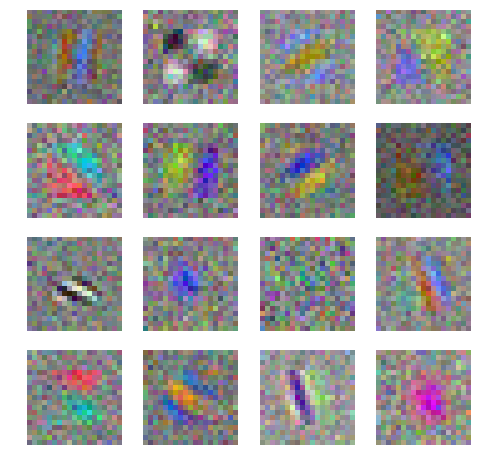

In [23]:
plt.figure(figsize=[8,8])
for ch in range(16):
    plt.subplot(4,4,ch+1)
    imshow_with_zoom(rf_rc_scaled[ch],zoom = True)
plt.savefig('{}/RF_rc'.format(fig_dir))

I compare the true weights and estimated RF in the following chapter 

# (3) estimating RF by activation maximization

In [9]:
def am_reg(layer_name,img,ch=0,pos=pos,lam1 =0.0001,lam2=0.0001,lr = 1,ite=100,pri = False,j=0,grad_clip = True):
    #layer_name : layer name
    #ch : channel
    #pos : position of unit (only for conv unit)
    #lam1 : coefficient of regularization term about norm
    #lam2 : coefficient of regularization term about smoothness
    #lr  : initial learning rate
    #ite : iteration of training
    
    img_reg = np.zeros([1,3,227,227]).astype(np.float32) + 128

    
    unit_act = -100
    for _ in range(ite):
        
        if j > 0:
            r_jitter = np.random.randint(-j,j+1,2)
            img = Variable(np.roll(np.roll(img.data,r_jitter[0],axis=2),r_jitter[1],axis=3))
        feature = model(img,layers=[layer_name])[layer_name]

        reg1   = F.mean((img - img_reg)**2)
        reg2_1 = F.mean((img[:,:,1:,:] - img[:,:,:-1,:])**2)
        reg2_2 = F.mean((img[:,:,:,1:] - img[:,:,:,:-1])**2)
        reg2 = reg2_1 + reg2_2
        
        
        if feature.data.ndim == 2:
            loss = -feature[0,ch] + lam1*reg1 + lam2*reg2
        else:
            loss = -feature[0,ch,pos[0],pos[1]] + lam1*reg1 + lam2*reg2



        img.cleargrad()
        loss.backward()
        grad = img.grad
        
        if grad_clip:
            img.data -= lr * grad / np.mean(np.abs(grad))
        else:
            img.data -= lr * grad
            
        if j > 0:
            img = Variable(np.roll(np.roll(img.data,-r_jitter[0],axis=2),-r_jitter[1],axis=3))
        
        if np.mod(_,10) == 0:
            if pri:
                print('----')
                print('iteration : {}'.format(_))
                print('loss      : {}'.format(loss.data))
            if feature.data.ndim == 2:
                if pri:
                    print('unit act  : {}'.format(feature[0,ch].data))
            else:
                unit_act = feature[0,ch,pos[0],pos[1]].data           
                if pri:
                    print('unit act  : {}'.format(feature[0,ch,pos[0],pos[1]].data))
    
    return img



In [61]:
#AM for RF
out_ch_len = 10
in_ch_len = 1
zure = 0

#estimate RF by AM
rf_am_img = []
for k in range(out_ch_len):
    print(k)
    img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
    img_conv1 = am_reg('conv1',img,ch=k,pri = False,lam1 = 0.001,lam2 = 0,lr = 1,j=0,ite = 20)
    rf_am_img.append(img_conv1.data)

rf_am_imgs = np.vstack(rf_am_img)
rf_am_scaled = scaling(rf_am_imgs)
rf_am_scaled = rf_am_scaled.transpose(0,2,3,1)

0
1
2
3
4
5
6
7
8
9


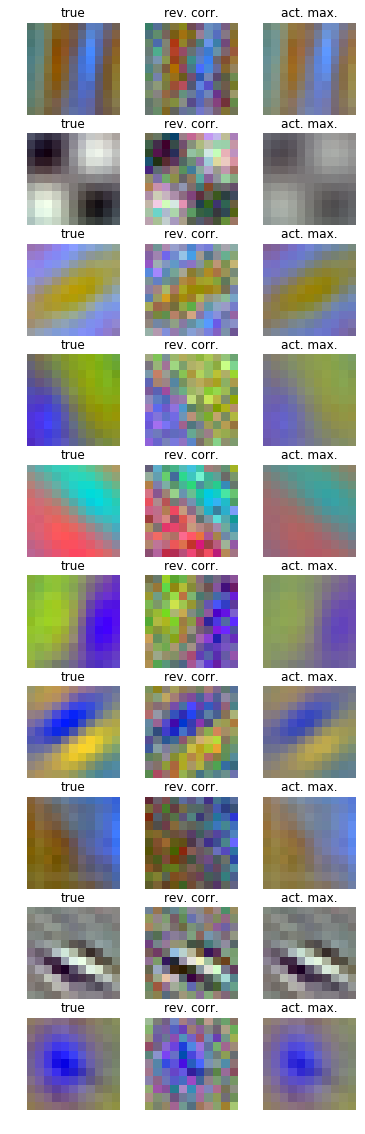

In [65]:
#plot
plt.figure(figsize=[6,2 * out_ch_len])
for out_ch in range(out_ch_len):
    for in_ch in range(in_ch_len):
        
        plt.subplot(out_ch_len,3,1 + 3*out_ch)
        true_weight = model.conv1.W.data[out_ch+zure].transpose(1,2,0)
        true_weight = scaling(true_weight)
        plt.imshow(true_weight)
        plt.axis('off')
        plt.title('true')
        plt.gray()
        
        plt.subplot(out_ch_len,3,2 + 3*out_ch)
        imshow_with_zoom(rf_rc_scaled[out_ch+zure,:,:],zoom=True,d=0)
        plt.title('rev. corr.')
        plt.gray()
        
        plt.subplot(out_ch_len,3,3 + 3*out_ch)
        imshow_with_zoom(rf_am_scaled[out_ch,:,:],zoom=True,d=0)
        plt.title('act. max.')
        plt.gray()
        

plt.savefig('{}/RF_rc_am.png'.format(fig_dir))

# (4) estimating prefered image by activation maximization (not only for first layer)

In [66]:
ch = 0
categories = np.loadtxt('{}/labels.txt'.format(data_dir), str, delimiter="\n")
categories[ch]

'tench, Tinca tinca'

In [98]:
img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
img_conv3 = am_reg('conv3',img,pos=np.array([5,5]),ch=ch,pri = False,lam1 = 0.0001,lam2 = 0.1,lr = 1,j=32,ite = 100)
img_conv3 = img_conv3.data

In [99]:
img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
img_fc6 = am_reg('fc6',img,ch=ch,pri = False,lam1 = 0.0001,lam2 = 0.1,lr = 1,j=32,ite = 200)
img_fc6 = img_fc6.data

In [100]:
img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
img_fc8 = am_reg('fc8',img,ch=ch,pri = False,lam1 = 0.0001,lam2 = 0.1,lr = 1,j=32,ite = 200)
img_fc8 = img_fc8.data

In [101]:
img_list = [img_conv3,img_fc6,img_fc8]
titles = ['conv3','fc6','fc8']

In [10]:
with open('./temp/am_imgs.pkl','rb') as f:
    img_list = pickle.load(f)

In [11]:
def show_chainer(x):
    x = scaling(x)
    plt.imshow(x[0,[2,1,0],:,:].transpose(1,2,0).astype(np.float32))
    plt.axis('off') 

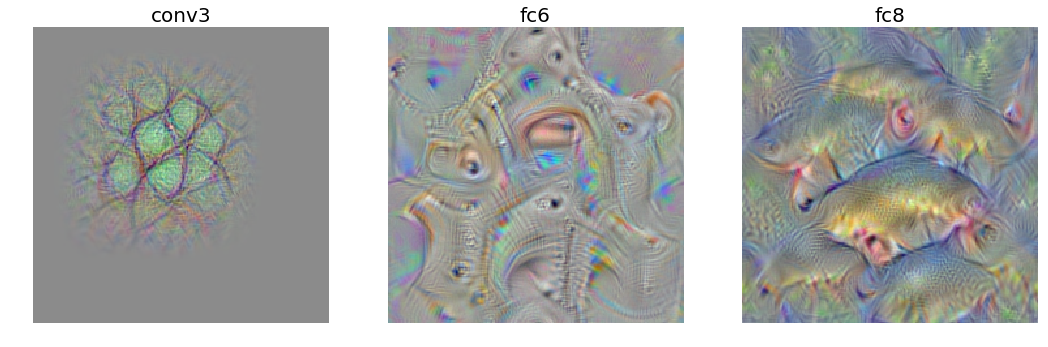

In [14]:
plt.figure(figsize = [18,6])
for k in range(len(img_list)):
    plt.subplot(1,len(img_list),k+1)
    show_chainer(img_list[k])
    plt.title(titles[k],fontsize = 20)

plt.savefig('{}/activation_maximization'.format(fig_dir))

In [18]:
check_label(model(img_fc8,layers='prob')['prob'])

  1 100.00% tench, Tinca tinca
  2   0.00% barracouta, snoek
  3   0.00% coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch
  4   0.00% gar, garfish, garpike, billfish, Lepisosteus osseus
  5   0.00% sturgeon
  6   0.00% eel
  7   0.00% axolotl, mud puppy, Ambystoma mexicanum
  8   0.00% goldfish, Carassius auratus
  9   0.00% puffer, pufferfish, blowfish, globefish
 10   0.00% tiger shark, Galeocerdo cuvieri


# (5) encoding and decoding experiment using Alexnet

In [19]:
def collect_unit_act(model,img,label,n_unit,n_class,selected_unit_list):
    #collect unit activity with presenting image to Alexnet
    #model  : model such as Alexnet
    #img    : stimulus images
    #label  : classes of stimulus images
    #n_unit : how many unit
    #n_class: how many class
    #selected_unit_list : which unit you use
    
    #return : dictionary containing unit activities and class information
    d = {}
    for ln in ln_list:
        d[ln] = []
    d['class'] = []

    for cl in range(n_class):
        d['class'].append(cl)
        feature = model(img[label == cl][:n_unit],layers=ln_list)
        for ln,su in zip(ln_list,selected_unit_list):
            temp = feature[ln][:].data
            d[ln].append(temp.reshape(len(temp),temp.size/len(temp))[:,su])
    return d


def log_gauss_p(x,m,sig):
    # return logarithm of gaussian probability 
    sig = sig + 1e-8
    return -0.5 * np.log(2 * np.pi) - np.log(sig) - (x-m)**2/2/sig**2

def inference(x,m_list,s_list,n_class):
    # infer class
    
    # x : unit activity that you want to estimate the class
    # m_list : mean of train unit activities
    # s_list : std  of train unit activities
    # n_class : number of candidate class
    p = []
    for k in range(n_class):
        p.append(np.sum(log_gauss_p(x,m_list[k],s_list[k])))
    return np.argmax(p)




In [20]:
def encode_decode(data,n_unit,n_train,n_test,model):
    #n_class = len(data['Category'])
    n_class = 4
    
    #prepare data
    img_train = np.array(data['ImageTrain']).transpose(0,3,1,2).astype(np.float32)
    img_train = img_train[:,[2,1,0],:,:]
    label_train = np.array(data['LabelTrain'])
    img_test = np.array(data['ImageTest']).transpose(0,3,1,2).astype(np.float32)
    img_test = img_test[:,[2,1,0],:,:]
    label_test = np.array(data['LabelTest'])


    #initialize
    feature = model(img_train[0:1], layers=ln_list)
    n_unit_list = [len(feature[ln].data.flatten()) for ln in ln_list]
    selected_unit_list = [np.random.permutation(n_unit_ori)[:n_unit] for n_unit_ori in n_unit_list]

    # collect unit activity using training data
    print('collecting train data')
    d_train = collect_unit_act(model,img_train,label_train,n_train,n_class,selected_unit_list)

    # collect unit activity using testing data
    print('collecting test data')
    d_test = collect_unit_act(model,img_test,label_test,n_test,n_class,selected_unit_list)

    train = pd.DataFrame(d_train)
    test = pd.DataFrame(d_test)

    #最優推定
    #ユニットの活動はガウシアンであると仮定
    print('estimating')
    acc_list = []
    for ln in ln_list:
        #data preparation
        x_train = np.stack(train[ln].values)
        x_train = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])

        y_train = train['class'].values
        y_train = np.repeat(y_train,n_train)
        x_test = np.stack(test[ln].values)
        x_test = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])
        y_test = test['class'].values
        y_test = np.repeat(y_test,n_test)
        

        #train (estimate mean and std in each class)
        m_list = []
        s_list = []
        for k in range(n_class):
            temp = x_train[y_train == k]
            m = np.mean(temp,axis=0)
            s = np.std (temp,axis=0)
            m_list.append(m)
            s_list.append(s)
        #ML
        pred = []
        for k in range(len(x_test)):
            pred.append(inference(x_test[k,:],m_list,s_list,n_class))

        acc = np.mean(np.array(pred) == y_test)
        acc_list.append(acc)
    

#     plt.figure(figsize=[20,10])
#     plt.plot(acc_list)
#     plt.hlines(1.0/n_class,0,len(acc_list))
#     a = plt.xticks(np.arange(len(acc_list)),ln_list)
#     plt.ylabel('accuracy')
#     plt.xlabel('layer name')
    
    return acc_list

In [14]:
#load image data
with open('./data/Orientation.pickle','rb') as f:
    data_orientation = pickle.load(f)
with open('./data/ImageNet.pickle','rb') as f:
    data_image = pickle.load(f)
with open('./data/FMD.pickle','rb') as f:
    data_fmd = pickle.load(f)
    

In [15]:
#setting
ln_list = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
n_unit=1000 #number of unit used in this analysis ( n <= 1000)
model.dropout_rate = 0.5 
n_train = 40 #training data size (n <= 40)
n_test = 10 #testing data size (n <= 10)


In [ ]:
# perform encoding decoding analysis
print('orientation start')
acc_orientation = encode_decode(data_orientation,n_unit,n_train,n_test,model)
print('imagenet start')
acc_imagenet = encode_decode(data_image,n_unit,n_train,n_test,model)
print('FMD start')
acc_fmd = encode_decode(data_fmd,n_unit,n_train,n_test,model)

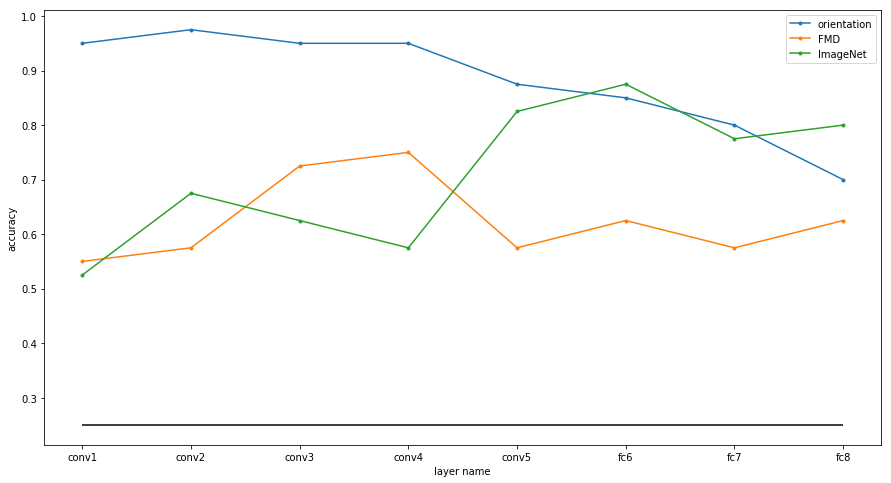

In [75]:
#plot
plt.figure(figsize=[15,8])
plt.plot(acc_orientation,'.-',label = 'orientation')
plt.plot(acc_fmd,'.-',label = 'FMD')
plt.plot(acc_imagenet,'.-',label = 'ImageNet')
plt.hlines(1.0/4,0,len(acc_fmd)-1)
a = plt.xticks(np.arange(len(acc_fmd)),ln_list)
plt.ylabel('accuracy')
plt.xlabel('layer name')
plt.legend()
plt.savefig('{}/enc_dec_acc'.format(fig_dir))

# (6) estimating tuning curve for orientation stimulus

In [108]:
def make_data(theta,omega,k=0,show = False):
    # make orientation image
    img = make_orientation_image(theta=theta,omega = omega,k = k,size = 227)
    img = img.astype(np.float32)
    img = np.expand_dims(img.transpose(2,0,1),axis=0)
    return img
def make_orientation_image(theta,omega,k = 0,size = 227):
    # make orientation image
    x = np.arange(-size/2.0,size/2.0)
    y = np.arange(-size/2.0,size/2.0)

    xx = np.matlib.repmat(x,len(x),1)
    yy = np.matlib.repmat(y,len(y),1).T
    
    xy_rotation = xx*np.cos(theta)-yy*np.sin(theta)
    wave = np.cos(xy_rotation*omega+k)
    temp = wave - np.min(wave)
    wave = temp / np.max(temp)*255
    wave = np.stack([wave]*3,axis=2).astype(np.uint8)
    return(wave)

def pi_to_deg(x):
    return x/np.pi*180
    

In [423]:
#show orientation image to the model
m_list = []
s_list = []

n_ori = 32 # 
omega = 0.01 * 65

for k in range(n_ori + 1):
    img = make_data(np.pi /n_ori * k,omega)
    fea = F.relu(model(img,layers=['conv1'])['conv1'])[0].data
    m = [np.mean(f) for f in fea]
    s = [np.std(f) for f in fea]
    m_list.append(m)
    s_list.append(s)
    
s_list = np.array(s_list)
m_list = np.array(m_list)

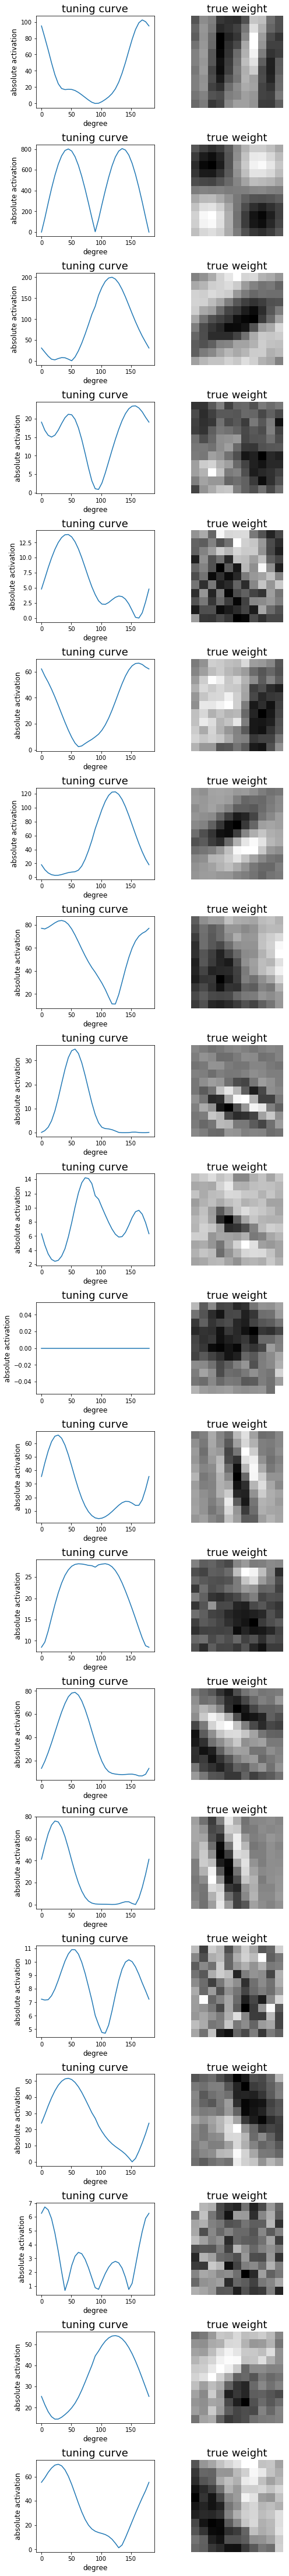

In [424]:
#plot
n_plot = 20
plt.figure(figsize=[4*2,4*n_plot])
for ch in range(n_plot):
    plt.subplot(n_plot,2,2*ch+1)

    temp_tuning = m_list[:,ch]
    temp_x = pi_to_deg(1.0 * np.arange(n_ori+1)/n_ori * np.pi)
    plt.plot(temp_x, temp_tuning)
    plt.ylabel('absolute activation',fontsize=12)
    plt.xlabel('degree',fontsize=12)
    plt.title('tuning curve',fontsize=18)

    plt.subplot(n_plot,2,2*ch+2)
    
    wei = np.mean(model.conv1.W[ch].transpose(1,2,0).data,axis=2)
    plt.imshow(wei)
    plt.axis('off')
    plt.title('true weight',fontsize = 18)
    
plt.subplots_adjust(hspace = 0.4)
plt.savefig('{}/tuning_curve_and_weight'.format(fig_dir))

# (7) decoding orientation using estimated tuning curve

In [105]:
theta_cand = np.linspace(0,np.pi,100)
ans_rec = []
for theta in theta_cand:
    img = make_data(theta,0.01 * 65,show = False)
    img = np.expand_dims(img,axis=0)
    fea = F.relu(model(img,layers=['conv1'])['conv1']).data[0]
    
    #それぞれのchからユニットを一つずつ取ってくる
    b = [np.random.choice(fea[k].flatten()) for k in range(len(fea))]
    b = np.array(b)

    #尤度
    log_p = 0
    for k in range(len(b)):
        if np.random.rand() < 0.5:#約半分のチャネル
            m_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,m_list[:,k])
            s_interpolated = interpolate.interp1d(np.arange(33) * np.pi / 32.0,s_list[:,k])
            m = m_interpolated(theta_cand)
            s = s_interpolated(theta_cand)
            log_p += log_gauss_p(b[k],m,s)
    ans = theta_cand[np.argmax(log_p)]
    ans_rec.append(ans)

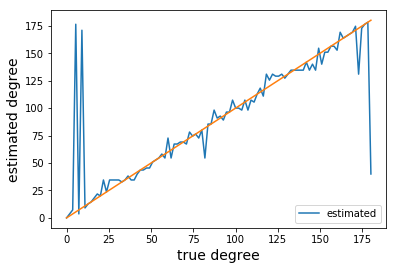

In [106]:
#plot
plt.plot(theta_cand/np.pi*180,np.array(ans_rec)/np.pi*180,label = 'estimated')
plt.plot(theta_cand/np.pi*180,theta_cand/np.pi*180)
plt.xlabel('true degree',fontsize = 14)
plt.ylabel('estimated degree',fontsize = 14)
plt.legend()
plt.savefig('{}/orientation_decoding'.format(fig_dir))

# (8) inverse CNN

In [21]:
def inverse_cnn(layer_name,img,fea_target = None,lam1 =0.0001,lam2=0.0001,lr = 1,ite=100,pri = False,j=0,grad_clip = True):
    #layer_name : layer name
    #fea_target : target feature obtained from original image
    #pos : position of unit (only for conv unit)
    #lam1 : coefficient of regularization term about norm
    #lam2 : coefficient of regularization term about smoothness
    #lr  : initial learning rate
    #ite : iteration of training
    
    img_reg = np.zeros([1,3,227,227]).astype(np.float32) + 128

    
    unit_act = -100
    for _ in range(ite):
        
        if j > 0:
            r_jitter = np.random.randint(-j,j+1,2)
            img = Variable(np.roll(np.roll(img.data,r_jitter[0],axis=2),r_jitter[1],axis=3))
        feature = model(img,layers=[layer_name])[layer_name]

        reg1   = F.mean((img - img_reg)**2)
        reg2_1 = F.mean((img[:,:,1:,:] - img[:,:,:-1,:])**2)
        reg2_2 = F.mean((img[:,:,:,1:] - img[:,:,:,:-1])**2)
        reg2 = reg2_1 + reg2_2
        
        
        loss = F.mean((feature - fea_target)**2) + lam1*reg1 + lam2*reg2


        img.cleargrad()
        loss.backward()
        grad = img.grad
        
        if grad_clip:
            img.data -= lr * grad / np.mean(np.abs(grad))
        else:
            img.data -= lr * grad
            
        if j > 0:
            img = Variable(np.roll(np.roll(img.data,-r_jitter[0],axis=2),-r_jitter[1],axis=3))
        
        if np.mod(_,10) == 0:
            if pri:
                print('----')
                print('iteration : {}'.format(_))
                print('loss      : {}'.format(loss.data))

    return img



In [32]:
img_ori = Image.open('{}/lion.png'.format(data_dir))
img_ori = prepare(img_ori)

/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [33]:
ln_list = ['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
#ln_list = ['fc6']
img_result_list = []
fea_size_list = []
for ln in ln_list:
    print(ln)
    model.dropout_rate = 0.1
    fea_target = model(img_ori,layers = ln)[ln]
    model.dropout_rate = 0
    fea_size_list.append(fea_target.size)
    img = Variable(np.random.rand(1,3,227,227).astype(np.float32))
    img = inverse_cnn(ln,img,fea_target,pri = True,ite = 300,lam1 =0.01,lam2 = 0.1,lr = 1)
    img = inverse_cnn(ln,img,fea_target,pri = True,ite = 300,lam1 =0.01,lam2 = 0.1,lr = 0.1)
    img_result_list.append(img.data)
    #show(img_result_list[-1].astype(np.uint8))
# plt.figure(figsize=[20,20])
# show(img)
# plt.axis('off')

conv1
----
iteration : 0
loss      : 7134.87060546875
----
iteration : 10
loss      : 3269.63818359375
----
iteration : 20
loss      : 1980.86181640625
----
iteration : 30
loss      : 1537.78759765625
----
iteration : 40
loss      : 1232.6171875
----
iteration : 50
loss      : 980.4017944335938
----
iteration : 60
loss      : 765.6215209960938
----
iteration : 70
loss      : 581.8781127929688
----
iteration : 80
loss      : 426.3432922363281
----
iteration : 90
loss      : 297.72430419921875
----
iteration : 100
loss      : 222.02450561523438
----
iteration : 110
loss      : 179.86669921875
----
iteration : 120
loss      : 148.36981201171875
----
iteration : 130
loss      : 124.7599868774414
----
iteration : 140
loss      : 107.0046157836914
----
iteration : 150
loss      : 93.61701965332031
----
iteration : 160
loss      : 83.50985717773438
----
iteration : 170
loss      : 75.86609649658203
----
iteration : 180
loss      : 70.0909194946289
----
iteration : 190
loss      : 65.738357543

----
iteration : 120
loss      : 83.80773162841797
----
iteration : 130
loss      : 83.02401733398438
----
iteration : 140
loss      : 82.2509536743164
----
iteration : 150
loss      : 81.51266479492188
----
iteration : 160
loss      : 80.74822235107422
----
iteration : 170
loss      : 80.00988006591797
----
iteration : 180
loss      : 79.26885986328125
----
iteration : 190
loss      : 78.57202911376953
----
iteration : 200
loss      : 77.90553283691406
----
iteration : 210
loss      : 77.28336334228516
----
iteration : 220
loss      : 76.55538177490234
----
iteration : 230
loss      : 75.88504791259766
----
iteration : 240
loss      : 75.21368408203125
----
iteration : 250
loss      : 74.56012725830078
----
iteration : 260
loss      : 73.9390640258789
----
iteration : 270
loss      : 73.33613586425781
----
iteration : 280
loss      : 72.6634292602539
----
iteration : 290
loss      : 72.00464630126953
conv4
----
iteration : 0
loss      : 271.631103515625
----
iteration : 10
loss      :

----
iteration : 230
loss      : 79.738525390625
----
iteration : 240
loss      : 76.7140121459961
----
iteration : 250
loss      : 73.21526336669922
----
iteration : 260
loss      : 70.89661407470703
----
iteration : 270
loss      : 67.67132568359375
----
iteration : 280
loss      : 66.53553009033203
----
iteration : 290
loss      : 62.780052185058594
----
iteration : 0
loss      : 63.533851623535156
----
iteration : 10
loss      : 55.973228454589844
----
iteration : 20
loss      : 54.36048126220703
----
iteration : 30
loss      : 53.19438934326172
----
iteration : 40
loss      : 52.177757263183594
----
iteration : 50
loss      : 51.274803161621094
----
iteration : 60
loss      : 50.4421272277832
----
iteration : 70
loss      : 49.670806884765625
----
iteration : 80
loss      : 48.929115295410156
----
iteration : 90
loss      : 48.19464111328125
----
iteration : 100
loss      : 47.509796142578125
----
iteration : 110
loss      : 46.83039855957031
----
iteration : 120
loss      : 46.26

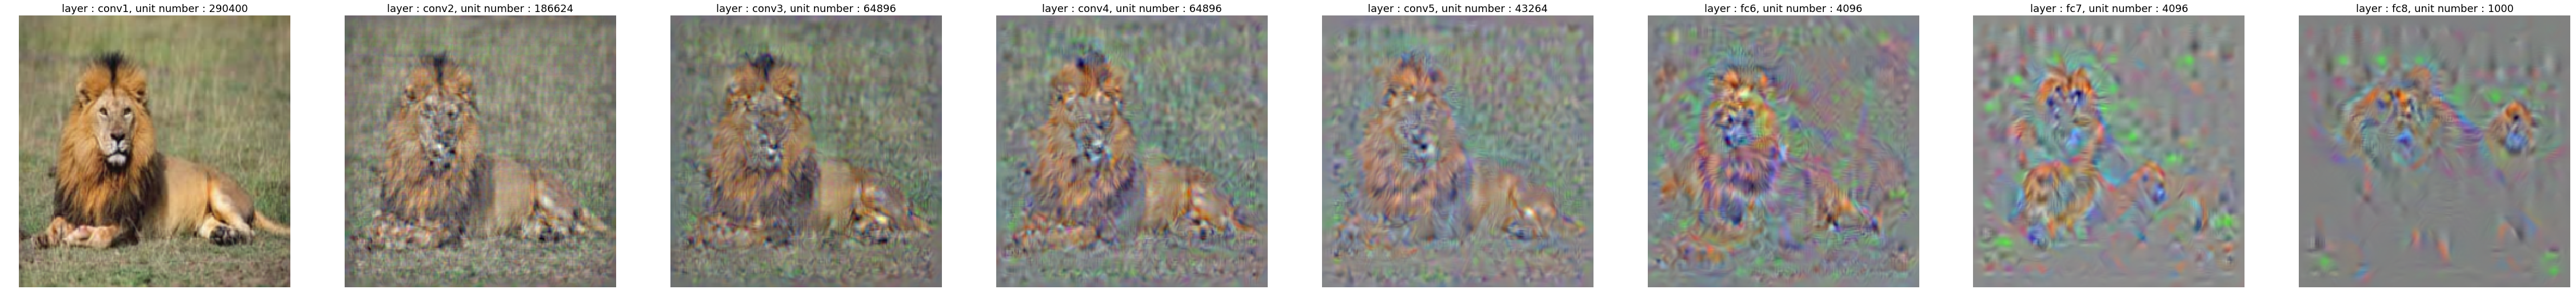

In [55]:
plt.figure(figsize=[80,10])
for k in range(len(img_result_list)):
    plt.subplot(1,len(img_result_list),k+1)
    show_chainer(img_result_list[k])
    plt.title('layer : {}, unit number : {}'.format(ln_list[k],fea_size_list[k]),fontsize = 18)
    plt.axis('off')
plt.savefig('{}/icnn'.format(fig_dir))

# おまけ

# deepdream googlenet

In [5]:
import numpy as np
import chainer
from chainer.links import caffe

class CaffeNet(caffe.CaffeFunction):
    def __init__(self, model_path):
        super(CaffeNet, self).__init__(model_path)

    def preprocess(self, image):
        return np.rollaxis(image[:,:,::-1] - self.mean, 2)

    def deprocess(self, image):
        return (np.rollaxis(image, 0, image.ndim) + self.mean)[:,:,::-1]

class GoogleNet(CaffeNet):
    def __init__(self, model_path):
        super(GoogleNet, self).__init__(model_path)
        self.mean = np.asarray([104, 116, 122], dtype=np.float32)

    def __call__(self, x, outputs=['loss3/classifier']):
#        return self.func(inputs={'data': x}, outputs=outputs, disable=['loss1/ave_pool', 'loss2/ave_pool'], train=False)
        return super(GoogleNet, self).__call__(inputs={'data': x}, outputs=outputs, disable=['loss1/ave_pool', 'loss2/ave_pool', 'inception_4d/1x1', 'inception_4d/3x3_reduce', 'inception_4d/5x5_reduce', 'inception_4d/pool'])


In [6]:

def scaling(img):
    #最大値を1、最小値が0になるように線形変換をする。
    temp = img - np.min(img)
    temp = temp/np.max(temp)
    return temp

In [7]:
def show(x):
    plt.imshow(x.astype(np.uint8)[0,[2,1,0],:,:].transpose(1,2,0))

In [44]:
def update(img,model,ln):

    step_size = 1.5
    step_num = 10
    oc_scale = 1.4
    oc_num = 3
    #ln = 'inception_3a/output'


    octaves = [img]
    for k in range(oc_num-1):
        octaves.append(nd.zoom(octaves[-1],(1,1,1/oc_scale,1/oc_scale),order = 1))

    detail = np.zeros_like(octaves[-1])
    detail_rec = []
    x_rec = []
    for octave_k,octave in enumerate(octaves[::-1]):

        h,w = detail.shape[2:]
        h0,w0 = octave.shape[2:]
        if octave_k > 0 :
            detail = nd.zoom(detail,(1,1,1.0 * h0/h,1.0 * w0/w),order=1)
        x = detail + octave
        for k in range(step_num):
            x = update_step(model,x,ln,step_size=step_size)

        detail = x - octave
        detail_rec.append(detail)
        x_rec.append(x)
    return x,detail_rec,x_rec

In [45]:
def update_step(model,x_ori,ln,step_size = 1.5,jitter = 32):
    rh,rw = np.random.randint(-jitter,jitter+1,2)
    x = np.roll(np.roll(x_ori,rh,axis = 2),rw,axis=3)
    
    x = Variable(x)
    #loss = F.sum(model(x,layers = [ln])[ln] ** 2)
    loss = F.sum(model(x,outputs = [ln])[0]**2)
    print(loss.data)
    x.cleargrad()
    loss.backward()
    x.data += step_size / np.mean(np.abs(x.grad)) * x.grad
    
    x = x.data
    
    x[x < 0] = 0
    x[x > 255] = 255 
    
    x = np.roll(np.roll(x,-rh,axis = 2),-rw,axis=3)
    
    
    return x

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imresize
from scipy import interpolate
import pickle
import pandas as pd
import time
import os

import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import serializers
from chainer import optimizers





In [38]:
model = GoogleNet('bvlc_googlenet.caffemodel')

In [39]:
img = Image.open('data/geese.png')
img = np.asarray(img).astype(np.float32)

img = np.expand_dims(img.transpose(2,0,1),axis=0)
img = img[:,[2,1,0],:,:]

In [40]:
import scipy.ndimage as nd

In [59]:
img = np.random.randn(1,3,200,200).astype(np.float32)*100 + 128

In [60]:
ln = 'inception_4c/output'

In [65]:
for k in range(10):
    img,detail_rec,x_rec = update(img,model,ln)

/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


53237490.0
44058760.0
48239376.0
59878876.0
46641370.0
65726644.0
60828956.0
47203256.0
60842544.0
62869388.0
149317710.0
138134620.0
166609570.0
167664590.0
161640590.0
181985070.0
185562420.0
174409660.0
187791680.0
186799700.0
257460160.0
285532700.0
292841660.0
299739040.0
298534500.0
292774820.0
294630600.0
306970050.0
319851040.0
282732830.0
58166780.0
53089840.0
54846800.0
58770010.0
65424410.0
63016200.0
76336700.0
61535772.0
64033216.0
67432540.0
162632780.0
149061260.0
160779140.0
168333580.0
174389260.0
164445650.0
180906820.0
183772020.0
170322670.0
176664110.0
286489020.0
292529250.0
307337920.0
312031680.0
331344900.0
316468200.0
290414460.0
312340640.0
325999200.0
275253820.0
59758790.0
50709516.0
56463564.0
71694650.0
69764970.0
59057104.0
69992760.0
57974330.0
66912316.0
75761920.0
156927660.0
174862030.0
180732270.0
164575000.0
186896510.0
185907820.0
179612270.0
167793220.0
207443800.0
207817600.0
288137280.0
275472420.0
280318820.0
320475330.0
308073300.0
290509900.

inception_4c/output


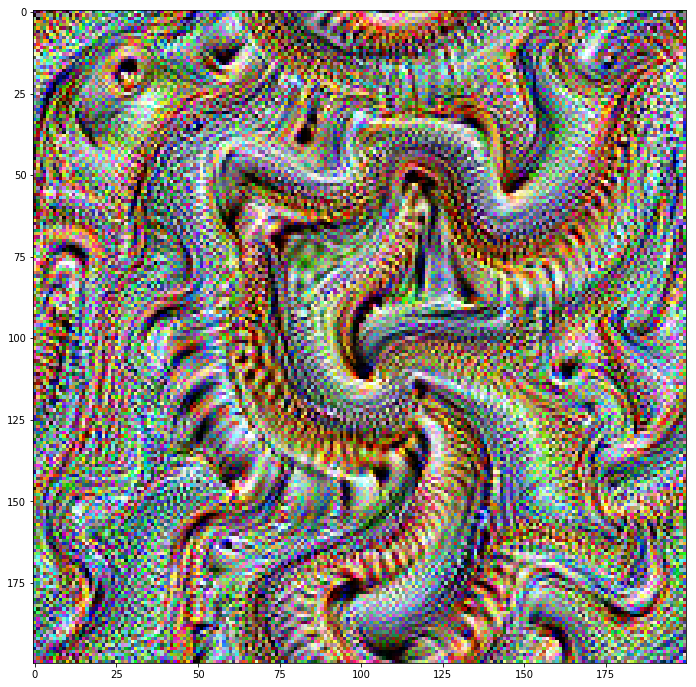

In [66]:
print(ln)
plt.figure(figsize=[12,12])
show(img)

inception_4c/output


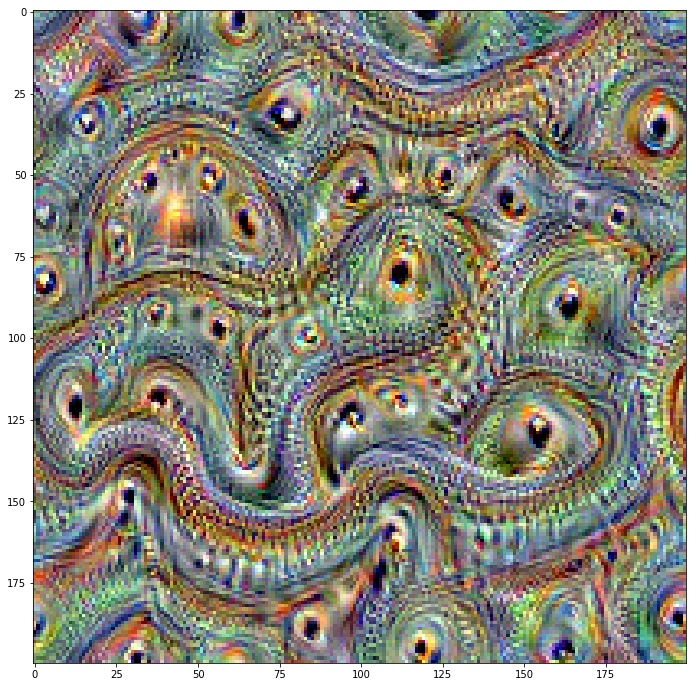

In [58]:
print(ln)
plt.figure(figsize=[12,12])
show(img)

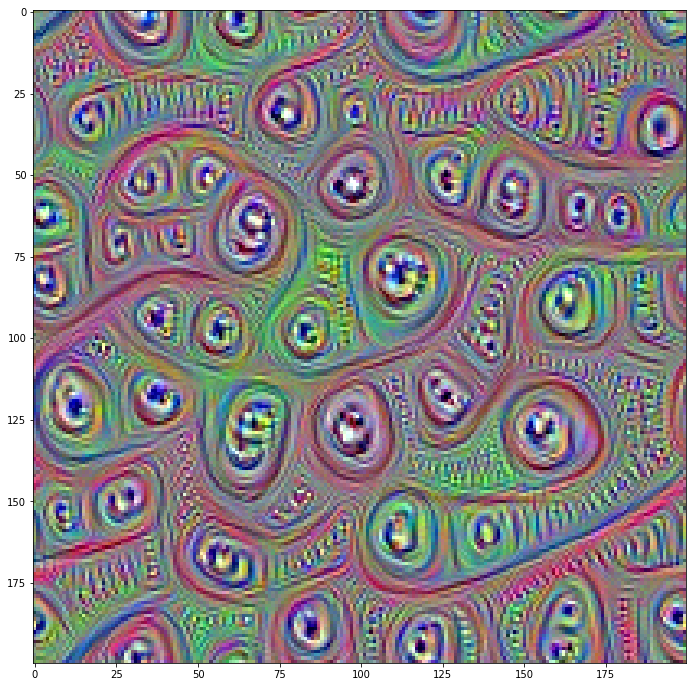

In [43]:
#'inception_3a/output'
plt.figure(figsize=[12,12])
show(img)

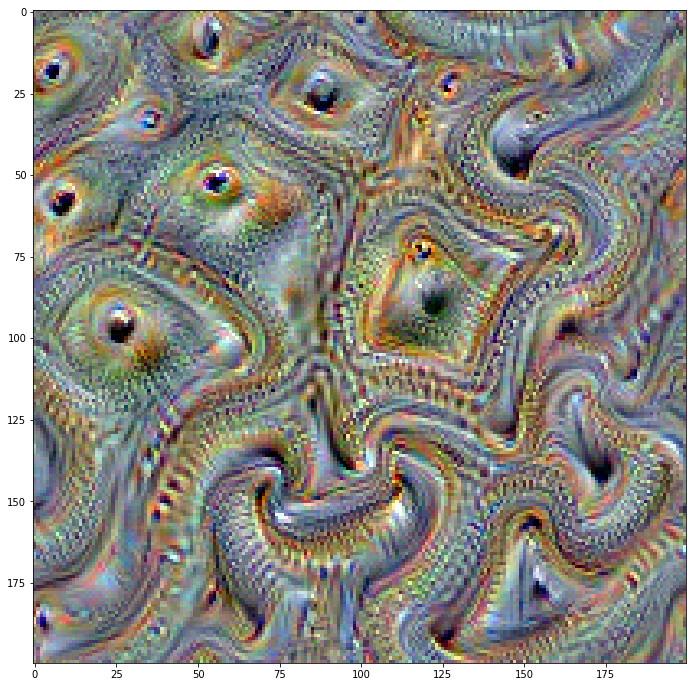

In [28]:
#'inception_4c/output'
plt.figure(figsize=[12,12])
show(img)

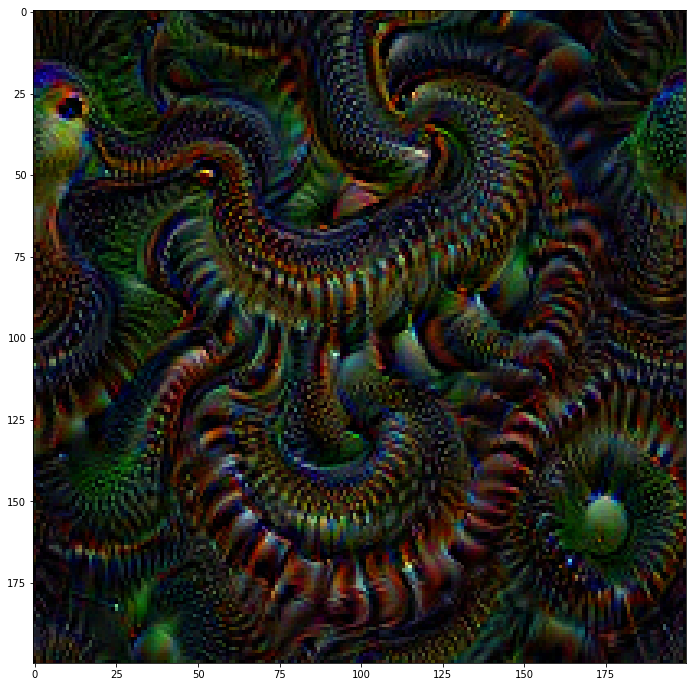

In [25]:
#'inception_4c/output'
plt.figure(figsize=[12,12])
show(img)

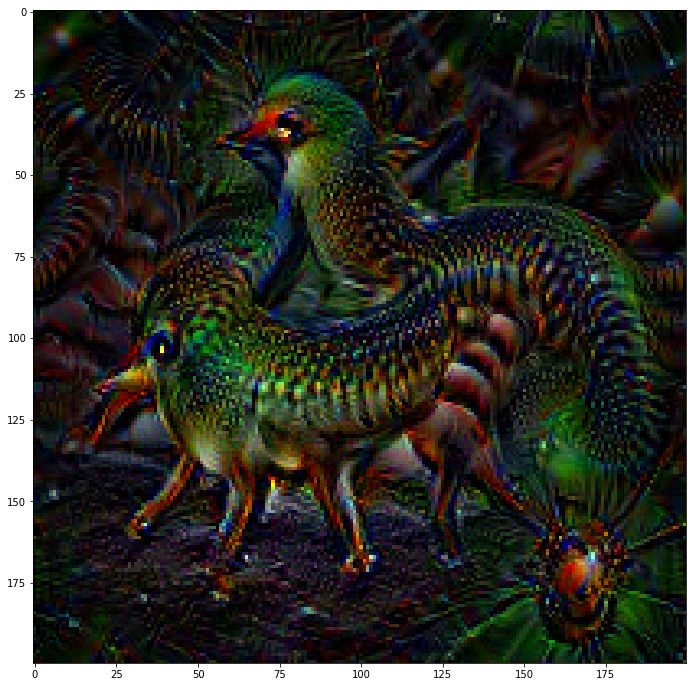

In [20]:
#'inception_4c/output'
plt.figure(figsize=[12,12])
show(img)

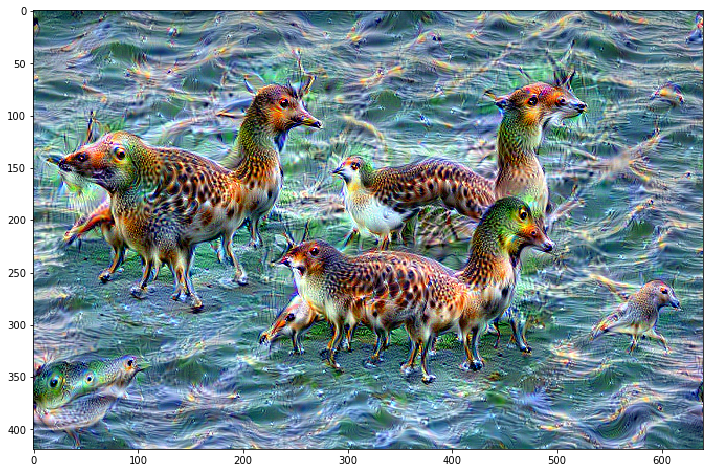

In [83]:
plt.figure(figsize=[12,12])
show(img)

# deepdream Alex

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imresize
from scipy import interpolate
import pickle
import pandas as pd
import time
import os

import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import serializers
from chainer import optimizers





In [203]:
import scipy.ndimage as nd

In [195]:

def scaling(img):
    #最大値を1、最小値が0になるように線形変換をする。
    temp = img - np.min(img)
    temp = temp/np.max(temp)
    return temp

In [196]:
def show(x):
    plt.imshow(x.astype(np.uint8)[0,[2,1,0],:,:].transpose(1,2,0))

In [262]:
def update(img,model):

    step_size = 1.5
    step_num = 10
    oc_scale = 1.4
    oc_num = 4
    #ln = 'inception_4c/output'
    ln = 'conv5'



    octaves = [img]
    for k in range(oc_num-1):
        octaves.append(nd.zoom(octaves[-1],(1,1,1/oc_scale,1/oc_scale),order = 1))

    detail = np.zeros_like(octaves[-1])
    detail_rec = []
    x_rec = []
    for octave_k,octave in enumerate(octaves[::-1]):

        h,w = detail.shape[2:]
        h0,w0 = octave.shape[2:]
        if octave_k > 0 :
            detail = nd.zoom(detail,(1,1,1.0 * h0/h,1.0 * w0/w),order=1)
        x = detail + octave
        for k in range(step_num):
            x = update_step(model,x,ln,step_size=step_size)

        detail = x - octave
        detail_rec.append(detail)
        x_rec.append(x)
    return x,detail_rec,x_rec

In [263]:
def update_step(model,x_ori,ln,step_size = 1.5,jitter = 64):
    rh,rw = np.random.randint(-jitter,jitter+1,2)
    x = np.roll(np.roll(x_ori,rh,axis = 2),rw,axis=3)
    
    x = Variable(x)
    loss = F.sum(model(x,layers = [ln])[ln] ** 2)
    #loss = F.sum(model(x,outputs = [ln])[0]**2)
    print(loss.data)
    x.cleargrad()
    loss.backward()
    x.data += step_size / np.mean(np.abs(x.grad)) * x.grad
    
    x = x.data
    
    x[x < 0] = 0
    x[x > 255] = 255 
    
    x = np.roll(np.roll(x,-rh,axis = 2),-rw,axis=3)
    
    
    return x

In [264]:
model = Alex()
serializers.load_hdf5('{}/Alex.h5'.format(model_dir),model)

In [265]:
img = Image.open('data/geese.png')
img = np.asarray(img).astype(np.float32)

img = np.expand_dims(img.transpose(2,0,1),axis=0)
img = img[:,[2,1,0],:,:]


In [280]:
img = np.random.randn(1,3,227,227).astype(np.float32) + 128

In [284]:
for k in range(10):
    img,detail_rec,x_rec = update(img,model)

/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1983072.6
1933202.2
1980491.2
1808641.5
2117897.5
1970860.5
2060706.2
2200626.0
2004397.4
1880432.6
4811569.0
4923269.5
5319588.0
4857139.5
5394300.5
5703451.0
5689400.0
5471497.5
5518447.5
6410535.0
11139398.0
14374671.0
15789118.0
14037107.0
15513096.0
14546740.0
13532684.0
16631280.0
19770476.0
16614505.0
43226076.0
40586440.0
42423560.0
41639336.0
47114200.0
52032120.0
50435640.0
47684508.0
58145304.0
52374356.0
2013552.2
1911824.2
2392251.0
1871978.5
2167484.5
2443623.5
2127097.0
2296582.5
2143341.2
2256011.5
5148790.0
5471076.5
5137458.0
5271997.0
5781069.5
5652772.5
5419588.0
5681201.0
6416539.5
5716742.5
15258008.0
15699135.0
15977380.0
15260901.0
16427663.0
16176331.0
19512006.0
18061628.0
16880994.0
14851335.0
39734340.0
43031850.0
40839676.0
46083556.0
53251416.0
48446210.0
56433252.0
48840000.0
53169150.0
54928560.0
1844908.4
1894126.5
2040217.6
1870304.0
2469661.8
2072015.8
2260145.5
2000716.9
2288100.8
2128111.5
4844988.0
5661113.5
5897077.5
5759803.5
6026120.5
5704357.5


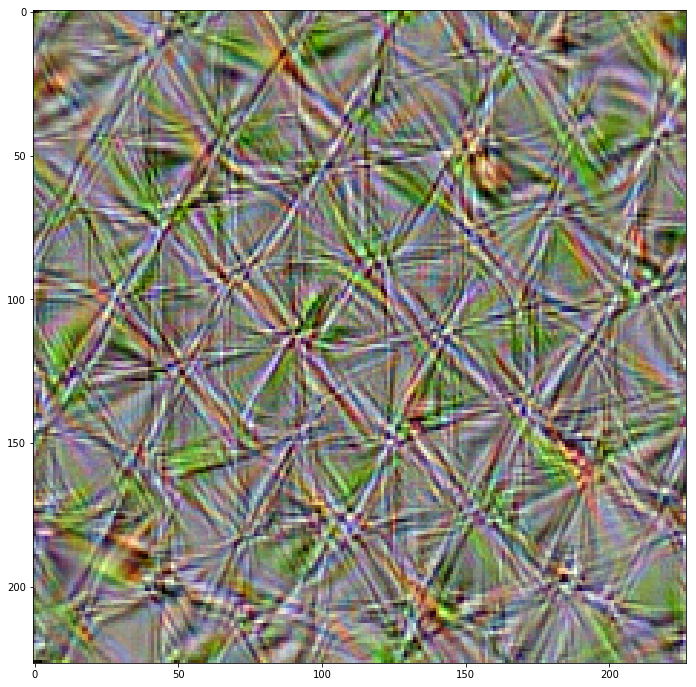

In [285]:
plt.figure(figsize=[12,12])
show(img)

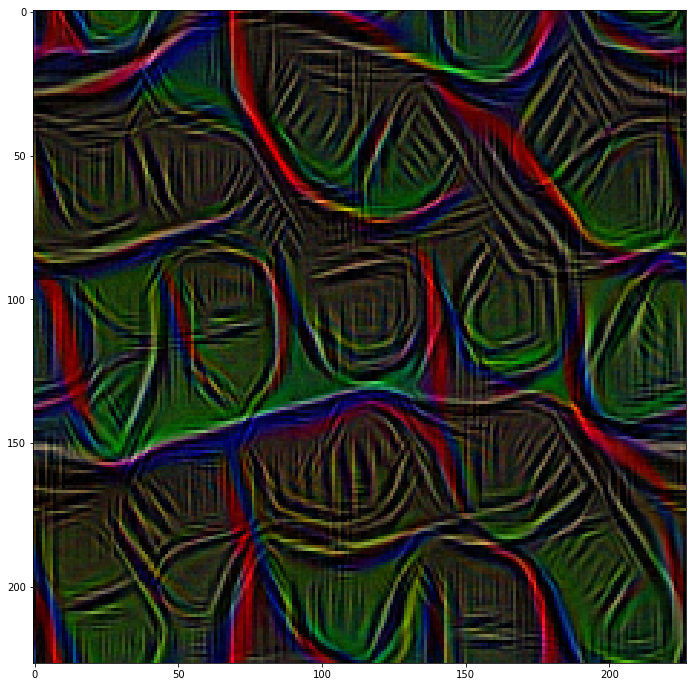

In [258]:
plt.figure(figsize=[12,12])
show(img)

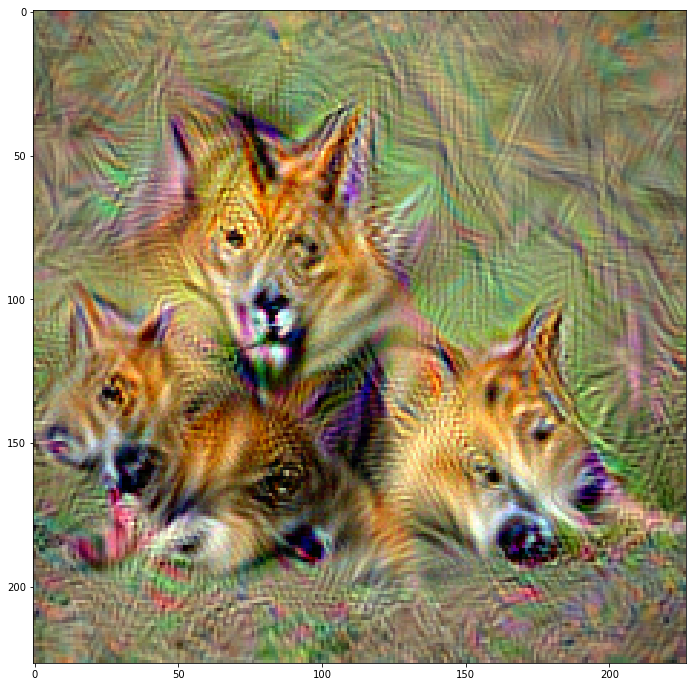

In [84]:
plt.figure(figsize=[12,12])
show(img)

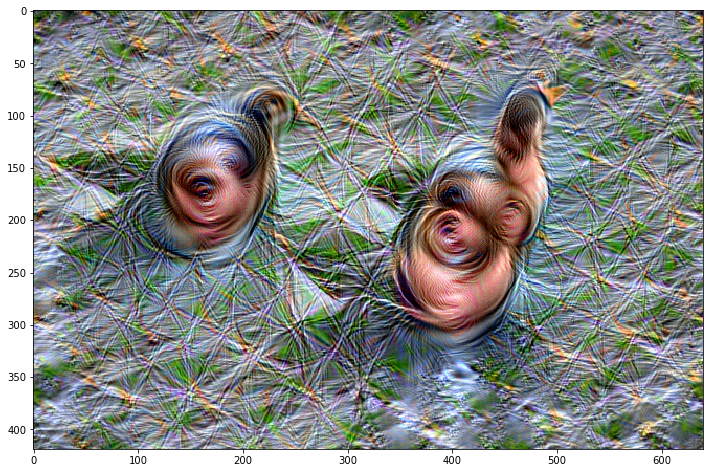

In [442]:
plt.figure(figsize=[12,12])
show(img)